In [2]:
import mdtraj as md
from sklearn.pipeline import Pipeline
from msmbuilder.io import load_trajs, load_meta, preload_tops
from msmbuilder.feature_extraction import DihedralFeaturizer
from msmbuilder.feature_selection import VarianceThreshold
from msmbuilder.preprocessing import RobustScaler
from msmbuilder.decomposition import tICA

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Introduction
This notebook will introduce using a Scikit-learn pipeline for processing MD data. 
The system we will be investigating is the folding of a model protein known as an FS-peptide (Ace-A5(AAARA) 3A-NME). 
The data consists of 28 MD trajectories. Each trajectory is 500 ns in length, and saved at a 50 ps time interval (14 microseconds aggegrate sampling).  The simulations were performed using the AMBER99SB-ILDN force field with GBSA-OBC implicit solvent at 300K, starting from randomly sampled conformations from an initial 400K unfolding simulation. The simulations were performed with OpenMM 6.0.1.

## tICA
The idea is that we will perform a dimensionality reduction techique called time-lagged Independent Component Analysis (tICA). It is very similar to Principle Component Analysis (PCA) but instead of finding linear combinations (eigenvectors) of the input data that maximize variance in the data, tICA finds combinations that maximize autocorrelations in the data for a given time lag ($\tau$). You can read more about it [here](http://docs.markovmodel.org/lecture_tica.html). 

The first tICA eigenvector tells you what the slowest (most correlated) motion the system undergoes *at a given time-lag*. The second eigenvector tells you the second slowest motion is etc. The associated eigenvalues  ($\lambda_{i}$) are related to the associated *implied time scales* ($t_{i}$) by 

$t_{i} = \frac{\tau}{log(\lambda_{i})} $

The tICA eigenvectors (especially the slowest one) have been shown to be very good reaction coordinates (see [here](http://aip.scitation.org/doi/full/10.1063/1.4974306)).  
You can read more about how tICA is used in representing the dynamics of biomolecules here

## Separation of timescales
As with all dimensionality reduction techniques we aim to throw away irrelevant portions of the data, or, put another way, we project our data onto the dominant eigenvectors of the tICA operator.  But where to we draw the line over how many eigenvectors to include?  

One way (and certainly not the only way) is to look at the separation of implied timescales, or the separation of eigenvalues. See [here](http://www.pnas.org/content/113/11/2839.full?sid=55cbc4f4-53bf-440c-a079-21a143dd4a50) for more information. 

It is often the case the there is a separation of the eigenvalues/implied timescales into two groups - a group of fast motions (e.g. vibrations/rotations) and a group of slow motions (e.g. folding). If we include only the eigenvectors associated with the slowest group of timescales, then our projection onto these eigenvectors will more accurately capture the slow dynamics of the system. 

This gap in the eigenvalues is called the spectral gap (we'll use this term from now on). 

## Hyperparameters
What affects the size of the spectral gap (for a given set of data)? There are many different factors which we will call **hyperparameters**. 

1. The way we represent the data: e.g. as cartesian coordinates, internal coordinates, residue separations, inverse distances, RMSD from folded state etc. 
2. What type of pre-processing we do: standardisation, median/interquartile scaling. 
3. The tICA lag time: if you plot the eigenvalues/timescales for different lag times (**hint: definitely do this**) you will see that a separation will definitely occur at some point. 

Note if you plan on using a descriptor that includes angles you must take `sine` and `cossine` of that angle instead, otherwise the tICA algorithm will fail.   

## The task

The task is to find the best description of protein folding using the separation of timescales to score the model.  Use cross validation to choose the hyperparameters and then score the final model on some held out data. 

You will need to set up a pipeline with a suitable parameter search strategy and run this over many iterations of hyperparameters in order to optmize the model.  

You can sample the data along a particular projection (e.g. the dominant eigenvector) and produce a movie of it using VMD to visually inspect your results i.e. it should look like it's folding/unfolding. 

## Machinery

This data is taken from [MSM Builder](http://msmbuilder.org/3.7.0/) and is designed to work with [Scikit Learn](http://scikit-learn.org/stable/). You should load these using [Anaconda](https://www.continuum.io/downloads). You should also download [Pandas](http://pandas.pydata.org/) (for data handling) and [Seaborn](http://seaborn.pydata.org/index.html) (for data visualisation). 

The MSMB functions should form the estimators of your pipeline, in particular you will need:

1. [Featurization](http://msmbuilder.org/3.7.0/featurization.html)
2. [Feature selection](http://msmbuilder.org/3.7.0/feature_selection.html)
3. [Preprocessing](http://msmbuilder.org/3.7.0/preprocessing.html)
4. [tICA](http://msmbuilder.org/3.7.0/decomposition.html). 

You can change them as you wish by wrapping them in a class of your own devising.  These classes should implement `fit` and `transform` (and `score` method for the final estimator)  methods so they can be used in a Scikit Learn pipeline.  

Note that there is also a sparse tICA and Kernel tICA implementations in MSMBuilder which implement [regularization](http://aip.scitation.org/doi/full/10.1063/1.4974306) and the [Kernel Trick](https://en.wikipedia.org/wiki/Kernel_method) for [tICA](http://pubs.acs.org/doi/abs/10.1021/ct5007357), respectively. 


## Alternatives scoring methods

### GMRQ
The tICA lag time can be optimized using separation of timescales.  However, if you pick a single tICA lag-time to work with (based off an initial investigation of the timescales) you may want to using the [GMRQ score](http://msmbuilder.org/3.3.0/examples/gmrq-model-selection.html) to optimize the other hyperparameters. Note you can only compare tICA models with **the same** lag-time using this method. In the example above they optimize the parameters of a Markov State Model but the same idea can be used for a tICA model. 

You may want to look at how models score jointly on the separation of timescales and GMRQ metric. 

### Markov State Model

tICA is often used as a preliminary step before making a Markov State Model (MSM). The next steps to making a MSM is clustering the data using e.g. Minibatch KMeans and then fitting a MSM model.  GMRQ can be used to score such a model.  The hyperparameters this adds are the type of clustering, number of clusters and the MSM lag time.  Ask me for more details. 




# tICA pipeline. 

The following notebook will go through constructing a simple pipeline for esimating a tICA model.  I've put this here to show you how to create a pipeline but note: It doesn't implement hyperparameter optimization using cross validation - see next workbook. 



## Load data

In [3]:
from msmbuilder.io import NumberedRunsParser, gather_metadata, save_meta
from msmbuilder.example_datasets import FsPeptide
fs_peptide = FsPeptide(verbose=False)
fs_peptide.get().trajectories
from os.path import join

homedir='/Users/robert_arbon/'
top_fn = join(homedir, 'msmbuilder_data/fs_peptide/fs-peptide.pdb')

# Get meta-data for trajectories
parser = NumberedRunsParser(traj_fmt='trajectory-{run}.xtc',
                            top_fn=top_fn,
                            step_ps=500)
meta = gather_metadata(join(homedir, 'msmbuilder_data/fs_peptide/*.xtc'), parser)
save_meta(meta)
meta.head()

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '
/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/msmbuilder/io/io.py:54: BackupWarning: meta.pandas.pickl exists. Moving it to meta.pandas.pickl.bak.8
  BackupWarning)


,nframes,step_ps,top_abs_fn,top_fn,traj_fn
run,,,,,
1,10000,500,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...
2,10000,500,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...
3,10000,500,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...
4,10000,500,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...
5,10000,500,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...,/Users/robert_arbon/msmbuilder_data/fs_peptide...


In [4]:
meta = load_meta('meta.pandas.pickl')
tops = preload_tops(meta)
trajs = [md.load(row['traj_fn'], top=tops[row['top_fn']], stride=10) 
         for i, row in meta.iterrows()]

/Users/robert_arbon/anaconda/envs/ml4dyn/lib/python3.5/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


### Set up the estimators for the pipeline
See (http://scikit-learn.org/stable/modules/pipeline.html) for more details. 

Each function must have a `fit` and `transform` function which fits a model and transforms the input data.  `fit` doesn't make sense for the featurizers (`features`), low variance removal (`variance`) or the scaling (`scaling`) functions so the `fit` functions for these steps do nothing. 
The only thing these functions do is transform the data. 


In [5]:
estimators = [('features', DihedralFeaturizer()), 
              ('variance', VarianceThreshold()),
              ('scaling', RobustScaler()), ('tICA', tICA())]
pipe = Pipeline(estimators)

### Manually set the parameters
This could have been done with the instantiations above but it's done separately here for clarity

In [6]:
pipe.set_params(features__types=['phi', 'psi'])
pipe.set_params(features__sincos=True)
pipe.set_params(variance__threshold=0.0) # Remove zero-variance features
pipe.set_params(scaling__with_centering=True)
pipe.set_params(scaling__with_scaling=True)
pipe.set_params(scaling__quantile_range=(25,75))
pipe.set_params(tICA__lag_time=500) # Time step is 500ps 
pipe.set_params(tICA__n_components=4) # Select only the first tICA components

Pipeline(steps=[('features', DihedralFeaturizer(sincos=True, types=['phi', 'psi'])), ('variance', VarianceThreshold(threshold=0.0)), ('scaling', RobustScaler(copy=True, quantile_range=(25, 75), with_centering=True,
       with_scaling=True)), ('tICA', tICA(kinetic_mapping=False, lag_time=500, n_components=4, shrinkage=None))])

### Run the pipeline
Now we pump the data through the pipeline by calling `fit`. Calling `fit` on the pipeline is the same as calling fit on each estimator in turn, transform the input and pass it on to the next step. The pipeline has all the methods that the last estimator in the pipeline has, i.e. if the last estimator is a classifier, the Pipeline can be used as a classifier. If the last estimator is a transformer, again, so is the pipeline.

In [7]:
pipe.fit(trajs)

Pipeline(steps=[('features', DihedralFeaturizer(sincos=True, types=['phi', 'psi'])), ('variance', VarianceThreshold(threshold=0.0)), ('scaling', RobustScaler(copy=True, quantile_range=(25, 75), with_centering=True,
       with_scaling=True)), ('tICA', tICA(kinetic_mapping=False, lag_time=500, n_components=4, shrinkage=None))])

### Do dimensionality reduction
Calling `fit` on the pipeline called `fit` and `transform` on each estimator in the pipeline, *except the last*.  Now we can call `transform` on the final estimator (`tICA`) and project all the trajectories onto the first four tICA components. 

In [8]:
tica_traj = pipe.transform(trajs)

In [9]:
print('Num trajectories: {0}; shape: {1}'.format(
    len(tica_traj), tica_traj[0].shape))

Num trajectories: 28; shape: (1000, 4)


Let's visualize a single trajectory (=`traj_num`) projected on the tICA components.   You can change which trajectory you look at and you'll see differences. 

We can use the parameters stored in the pipe - they're stored as a dictionary with the keys being the names we gave them when initialized

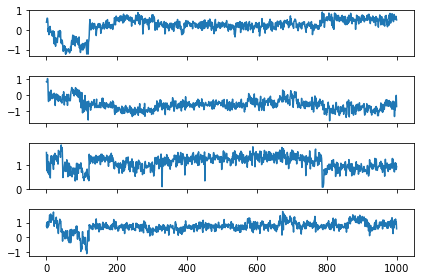

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
traj_num=6
n_components = pipe.get_params()['tICA__n_components']
fig, axes = plt.subplots(n_components, sharex=True)
for i in range(n_components):
    axes[i].plot(tica_traj[traj_num][:,i], label='tICA component: {}'.format(i))

plt.tight_layout()

We can also free energy plots by histogramming the data.  Hopefully we should see some metastable basins. 

### Exercise: Plot eigenvalues

Try extracting the first 50 timescales from the tICA object for a variety of tICA timelags. Set up a similar pipeline.  You'll keep everything the same as before except change `pipe.set_params(tICA__lag_time=500)` 
for each iteration of the loop.  You'll also need to change  `pipe.set_params(tICA__n_components=4)` once at the start of the loop. 

To get the timescales you'll need to access the `eigenvalues_` attribute of the tICA object.  The estimator objects can be accessed from the dictionary `pipe.named_steps`. 

In [11]:
import numpy as np
n_components=50
lags = np.arange(1, 600, 4)
eigenvalues = np.zeros((lags.shape[0], n_components))


# Set up pipeline
estimators = [('features', DihedralFeaturizer()), 
              ('variance', VarianceThreshold()),
              ('scaling', RobustScaler()), ('tICA', tICA())]
pipe = Pipeline(estimators)
pipe.set_params(features__types=['phi', 'psi'])
pipe.set_params(features__sincos=True)
pipe.set_params(variance__threshold=0.0) 
pipe.set_params(scaling__with_centering=True)
pipe.set_params(scaling__with_scaling=True)
pipe.set_params(scaling__quantile_range=(25,75))
pipe.set_params(tICA__n_components=n_components)

# Run loop
for idx, lag in enumerate(lags): 
    pipe.set_params(tICA__lag_time=int(lag))
    print('{}, '.format(lag), end='')
    pipe.fit(trajs)
    eigenvalues[idx] = pipe.named_steps['tICA'].eigenvalues_
    

1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 81, 85, 89, 93, 97, 101, 105, 109, 113, 117, 121, 125, 129, 133, 137, 141, 145, 149, 153, 157, 161, 165, 169, 173, 177, 181, 185, 189, 193, 197, 201, 205, 209, 213, 217, 221, 225, 229, 233, 237, 241, 245, 249, 253, 257, 261, 265, 269, 273, 277, 281, 285, 289, 293, 297, 301, 305, 309, 313, 317, 321, 325, 329, 333, 337, 341, 345, 349, 353, 357, 361, 365, 369, 373, 377, 381, 385, 389, 393, 397, 401, 405, 409, 413, 417, 421, 425, 429, 433, 437, 441, 445, 449, 453, 457, 461, 465, 469, 473, 477, 481, 485, 489, 493, 497, 501, 505, 509, 513, 517, 521, 525, 529, 533, 537, 541, 545, 549, 553, 557, 561, 565, 569, 573, 577, 581, 585, 589, 593, 597, 

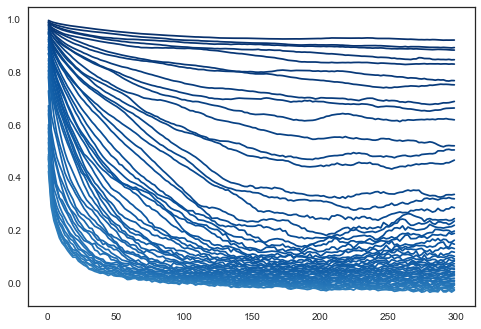

In [12]:
import seaborn as sns
to_ns=0.5
sns.set_palette('Blues_r', 168)
sns.set_style('white')
for idx in range(n_components):
    plt.plot(lags*0.5, eigenvalues.T[idx])